<a href="https://colab.research.google.com/github/rajbircit/assignments/blob/main/dl_a1/dl_assignment1_combined.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Mar 27 18:57:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P8    79W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
from keras.utils import np_utils
import numpy as np

import logging


import logging
import sys

root = logging.getLogger()
root.setLevel(logging.INFO)

handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
handler.setFormatter(formatter)
root.addHandler(handler)

# Open and read the Fashion MNIST database
Code copied from sample provided

In [3]:

def get_fashion_mnist_data()->tuple:
  """
  Returns the training (X,Y) and evaluation (X,Y)
  The features have already been reshaped and converted to
  floats in the range [0,1]

  Also, the Y has been converted to categorical data.
  """
  # load the training and test data    
  fashion_mnist = tf.keras.datasets.fashion_mnist
  (tr_x, tr_y), (te_x, te_y) = fashion_mnist.load_data()
  
  # reshape the feature data
  tr_x = tr_x.reshape(tr_x.shape[0], 784)
  te_x = te_x.reshape(te_x.shape[0], 784)
  
  # noramlise feature data
  tr_x = tr_x / 255.0
  te_x = te_x / 255.0
  logging.debug( "Shape of training features " + str(tr_x.shape))
  logging.debug( "Shape of test features " + str(te_x.shape))
  
  # one hot encode the training labels and get the transpose
  tr_y = np_utils.to_categorical(tr_y,10)
  tr_y = tr_y.T
  logging.debug("Shape of training labels " + str(tr_y.shape))
  
  # one hot encode the test labels and get the transpose
  te_y = np_utils.to_categorical(te_y,10)
  te_y = te_y.T
  logging.debug("Shape of testing labels " + str(te_y.shape))

  tr_x = tf.convert_to_tensor(tr_x, dtype=tf.float32)
  tr_y = tf.convert_to_tensor(tr_y, dtype=tf.float32)
  te_x = tf.convert_to_tensor(te_x, dtype=tf.float32)
  te_y = tf.convert_to_tensor(te_y, dtype=tf.float32)

  return tr_x, tr_y, te_x, te_y

# Some utility functions
1. Forward Pass
2. Cross Entropy (TODO)
3. Accuracy Score (TODO)
4. Flatten Network
5. Optimize Network (Adam)

In [61]:
def cross_entropy(y_true, y_pred):
  # TODO: RB: Reimplement this function yourself
  cce = tf.keras.losses.CategoricalCrossentropy()
  return cce(y_true, y_pred)

def accuracy(y_true:tf.Tensor, y_pred:tf.Tensor)->float:
  logging.debug("y_true = " + str(y_true.shape) + " y_pred = " + str(y_pred.shape))
  y_true = tf.transpose(y_true)
  logging.debug("y_true = " + str(y_true.shape) + " y_pred = " + str(y_pred.shape))
  eq = tf.math.equal(y_true, y_pred)
  return float(eq[eq == True].shape[0]) / float(eq.shape[0])

def mean_absolute_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  y_true = tf.transpose(y_true)
  logging.debug(y_true.shape, y_pred.shape)
  abs_dist = tf.math.abs(tf.math.subtract(y_true, y_pred))
  return tf.reduce_mean(abs_dist)

def mean_square_error(y_true:tf.Tensor, y_pred:tf.Tensor)->tf.Variable:
  return tf.reduce_mean(tf.math.squared_difference(y_true, y_pred))

def mean_square_error_image(yt:tf.Tensor, yp:tf.Tensor)->tf.Variable:
  y1 = tf.math.multiply(yt, 255.0)
  y2 = tf.math.multiply(yp, 255.0)
  return mean_square_error(tf.transpose(y1), y2)
  

class NeuralNetwork(object):
  def __init__(self, network):
    self.network = network
    self.iterations = []
    self.train_accuracies = []
    self.test_accuracies = []
    self.train_losses = []
    self.test_losses = []

  def forward_pass(self, tr_x, tr_y, layers):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in layers:
        if dropout:
          # TODO: Implement dropout
          dropout_filter = tf.Variable( \
                    tf.random.uniform( \
                      shape=input.shape, minval=0.0, maxval=1.0, dtype=tf.float32))
          dropout_filter = tf.math.greater(dropout_filter, 0.05)
          dropout_filter = tf.cast(dropout_filter, tf.float32)
          input = tf.math.multiply(input, dropout_filter)
        input = activation(tf.matmul(weight, input) + bias)
    return input
  
  def predict(self, tr_x, tr_y):
    input = tf.transpose(tr_x)
    for weight, bias, activation, dropout in self.network:
      input = activation(tf.matmul(weight, input) + bias)
    return input
  
  """
  Take a network which is a list of tuples, and flatten it
  to a list, so that we can call adam and gradient on it without 
  without any ugly code
  """
  def flatten_network(self, network:list)->list:
    out = []
    for weight, bias, act, dropout in network:
      out.append(weight)
      out.append(bias)
    return out
  
  """
  Use the adam optimizer to optimize a network based on the 
  gradients passed to it
  """
  def optimize_network(self, network:list, gradients:list)->None:
    adam_optimizer = tf.keras.optimizers.Adam()
    learnable_array = []
    adam_optimizer.apply_gradients(zip(gradients, \
                                       self.flatten_network(network)))
  
  def should_log(self, i:int, iterations:int):
    return (i == (iterations - 1)) or all([i == '0' for i in list(str(i)[1:])])
  
  """
  Train the network for a given number of iterations
  """
  def train_network(self, \
                    iterations:int, \
                    tr_x:tf.Tensor, tr_y:tf.Tensor, \
                    te_x:tf.Tensor, te_y:tf.Tensor, \
                    loss_fn, acc_fn, \
                    do_logging=True, \
                    use_argmax=True)->None:
    for i in range(iterations):
      with tf.GradientTape() as tape:
        y_pred = self.forward_pass(tr_x, tr_y, self.network)
        loss = loss_fn(tr_y, y_pred)
      gradients = tape.gradient(loss, self.flatten_network(self.network))

      if (use_argmax):
        tr_acc = acc = acc_fn(tf.argmax(tr_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        tr_acc = acc = acc_fn(tr_y, y_pred) if None != acc_fn else float("NaN")
      tr_loss = loss

      #if 0 == i % 50 or i < 20 or i == (iterations - 1):
      if self.should_log(i, iterations):
        printstr = f"Iteration {i:3d}  TRAIN LOSS - {loss:5.5f}  "
        printstr = printstr + f"TRAIN ACCURACY - {acc:5.5f}"

      y_pred = self.predict(te_x, te_y)
      te_loss = loss = loss_fn(te_y, y_pred)
      if (use_argmax):
        te_acc = acc = acc_fn(tf.argmax(te_y), tf.argmax(y_pred)) \
                if None != acc_fn else float("NaN")
      else:
        te_acc = acc = acc_fn(te_y, y_pred) if None != acc_fn else float("NaN")


      #if 0 == i % 50 or i < 20 or i == (iterations - 1):
      if self.should_log(i, iterations):
        printstr = printstr + f"  TEST_LOSS = {loss:5.5f}  "
        printstr = printstr + f"TEST ACCURACY = {acc:5.5f}"
        logging.info(printstr)

      self.iterations.append(i)
      self.train_accuracies.append(tr_acc)
      self.train_losses.append(tr_loss)
      self.test_accuracies.append(te_acc)
      self.test_losses.append(te_loss)

      self.optimize_network(self.network, gradients)

    self.iterations = np.array(self.iterations)
    self.train_accuracies = np.array(self.train_accuracies)
    self.train_losses = np.array(self.train_losses)
    self.test_accuracies = np.array(self.test_accuracies)
    self.test_losses = np.array(self.test_losses)

# Question 1_1_1

In [5]:
def q_1_1_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
                              
  # Layer 1 has 200 neurons, and 784 features,
  # hence the array should be (200, 784)
  l1_w = tf.Variable(tf.random.normal([200,784], mean=0, stddev=0.05, dtype=tf.dtypes.float32), name="L1 Weights")
  l1_b = tf.Variable(tf.zeros([200, 1],  dtype=tf.dtypes.float32), name="L1 Bias")
  
  l2_w = tf.Variable(tf.random.normal([10, 200], mean=0, stddev=0.05, dtype=tf.dtypes.float32), name="L2 Weights")
  l2_b = tf.Variable(tf.zeros([10, 1],  dtype=tf.dtypes.float32), name="L2 bias")
  
  network = [(l1_w, l1_b, tf.nn.relu, False), (l2_w, l2_b, tf.nn.softmax, False)]
  
  nn = NeuralNetwork(network)
  nn.train_network(1000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)
  return nn

2021-03-27 18:57:40,933 - root - INFO - Iteration   0  TRAIN LOSS - 66142.82812  TRAIN ACCURACY - 0.08670  TEST_LOSS = 9227.96387  TEST ACCURACY = 0.09110
2021-03-27 18:57:41,018 - root - INFO - Iteration   1  TRAIN LOSS - 64780.85156  TRAIN ACCURACY - 0.33817  TEST_LOSS = 9002.04883  TEST ACCURACY = 0.34670
2021-03-27 18:57:41,099 - root - INFO - Iteration   2  TRAIN LOSS - 63518.13672  TRAIN ACCURACY - 0.47018  TEST_LOSS = 8792.70605  TEST ACCURACY = 0.47470
2021-03-27 18:57:41,174 - root - INFO - Iteration   3  TRAIN LOSS - 62373.39844  TRAIN ACCURACY - 0.54748  TEST_LOSS = 8603.39258  TEST ACCURACY = 0.54430
2021-03-27 18:57:41,247 - root - INFO - Iteration   4  TRAIN LOSS - 61373.64844  TRAIN ACCURACY - 0.60112  TEST_LOSS = 8438.41016  TEST ACCURACY = 0.59830
2021-03-27 18:57:41,328 - root - INFO - Iteration   5  TRAIN LOSS - 60525.26172  TRAIN ACCURACY - 0.64230  TEST_LOSS = 8298.29297  TEST ACCURACY = 0.63920
2021-03-27 18:57:41,395 - root - INFO - Iteration   6  TRAIN LOSS - 59

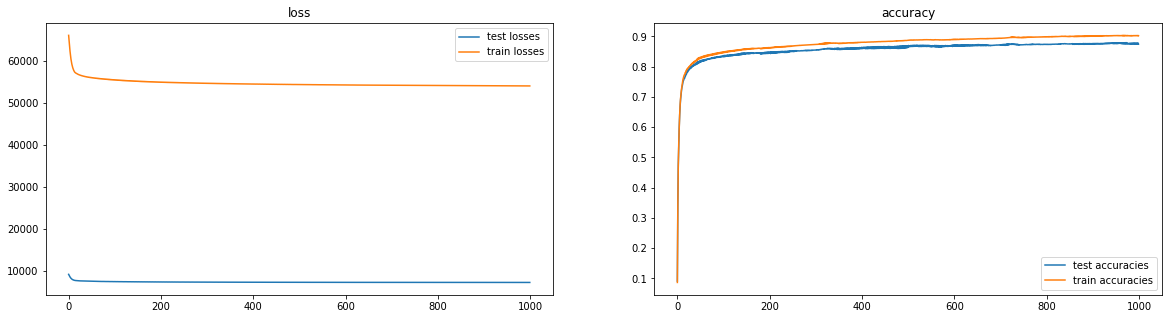

In [6]:
import matplotlib.pyplot as plt

nn = q_1_1_1()

plt.rcParams["figure.figsize"] = (20, 5)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(1, 2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
ax[0].set_title("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
ax[1].set_title("accuracy")
ax[1].legend()
plt.show()

In [7]:
def q_1_2_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  # Layer 1 has 200 neurons, and 784 features,
  # hence the array should be (200, 784)
  l1_w = tf.Variable(tf.random.normal([300,784], mean=0, stddev=0.05, dtype=tf.dtypes.float32), name="L1 Weights")
  l1_b = tf.Variable(tf.zeros([300, 1],  dtype=tf.dtypes.float32), name="L1 Bias")
  
  l2_w = tf.Variable(tf.random.normal([100,300], mean=0, stddev=0.05, dtype=tf.dtypes.float32), name="L2 Weights")
  l2_b = tf.Variable(tf.zeros([100, 1],  dtype=tf.dtypes.float32), name="L2 Bias")
  
  l3_w = tf.Variable(tf.random.normal([10, 100], mean=0, stddev=0.05, dtype=tf.dtypes.float32), name="L3 Weights")
  l3_b = tf.Variable(tf.zeros([10, 1],   dtype=tf.dtypes.float32), name="L3 bias")
  
  network = [(l1_w, l1_b, tf.nn.relu, False), (l2_w, l2_b, tf.nn.relu, False), (l3_w, l3_b, tf.nn.softmax, False)]
  
  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  
  nn = NeuralNetwork(network)
  nn.train_network(2000, tr_x, tr_y, te_x, te_y, cross_entropy, accuracy)

  return nn

2021-03-27 18:58:40,206 - root - INFO - Iteration   0  TRAIN LOSS - 66036.48438  TRAIN ACCURACY - 0.07590  TEST_LOSS = 9213.68262  TEST ACCURACY = 0.07400
2021-03-27 18:58:40,393 - root - INFO - Iteration   1  TRAIN LOSS - 65232.08594  TRAIN ACCURACY - 0.42338  TEST_LOSS = 9080.15918  TEST ACCURACY = 0.42210
2021-03-27 18:58:40,485 - root - INFO - Iteration   2  TRAIN LOSS - 64393.60547  TRAIN ACCURACY - 0.56715  TEST_LOSS = 8941.12695  TEST ACCURACY = 0.56500
2021-03-27 18:58:40,581 - root - INFO - Iteration   3  TRAIN LOSS - 63474.64844  TRAIN ACCURACY - 0.61663  TEST_LOSS = 8788.81152  TEST ACCURACY = 0.61740
2021-03-27 18:58:40,669 - root - INFO - Iteration   4  TRAIN LOSS - 62548.73828  TRAIN ACCURACY - 0.63908  TEST_LOSS = 8635.23730  TEST ACCURACY = 0.63860
2021-03-27 18:58:40,762 - root - INFO - Iteration   5  TRAIN LOSS - 61657.47656  TRAIN ACCURACY - 0.65052  TEST_LOSS = 8487.87695  TEST ACCURACY = 0.64940
2021-03-27 18:58:40,850 - root - INFO - Iteration   6  TRAIN LOSS - 60

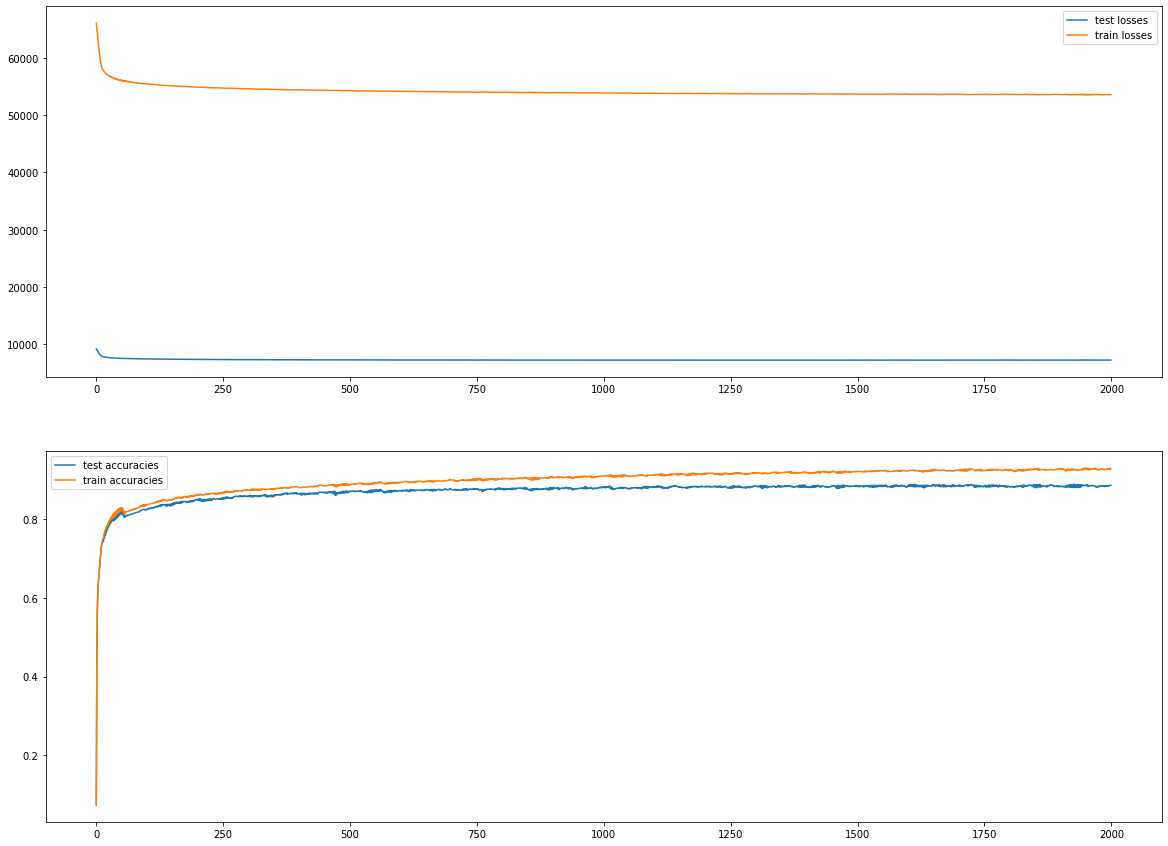

In [8]:
import matplotlib.pyplot as plt

nn = q_1_2_1()

plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

# Question 1_3_1
The first part of the question is to read the data set and inject noise into it
The second part is the autoencoder

## Read the data and inject noise

2021-03-27 20:40:59,059 - root - INFO - Iteration   0  TRAIN LOSS - 11100.58496  TRAIN ACCURACY - 11100.58496  TEST_LOSS = 11051.53125  TEST ACCURACY = 11051.53125
2021-03-27 20:40:59,220 - root - INFO - Iteration   1  TRAIN LOSS - 11066.66992  TRAIN ACCURACY - 11066.66992  TEST_LOSS = 11017.74805  TEST ACCURACY = 11017.74805
2021-03-27 20:40:59,372 - root - INFO - Iteration   2  TRAIN LOSS - 11031.89844  TRAIN ACCURACY - 11031.89844  TEST_LOSS = 10983.10742  TEST ACCURACY = 10983.10742
2021-03-27 20:40:59,520 - root - INFO - Iteration   3  TRAIN LOSS - 10993.62695  TRAIN ACCURACY - 10993.62695  TEST_LOSS = 10944.96777  TEST ACCURACY = 10944.96777
2021-03-27 20:40:59,663 - root - INFO - Iteration   4  TRAIN LOSS - 10949.46680  TRAIN ACCURACY - 10949.46680  TEST_LOSS = 10900.95410  TEST ACCURACY = 10900.95410
2021-03-27 20:40:59,806 - root - INFO - Iteration   5  TRAIN LOSS - 10894.62305  TRAIN ACCURACY - 10894.62305  TEST_LOSS = 10846.28125  TEST ACCURACY = 10846.28125
2021-03-27 20:40

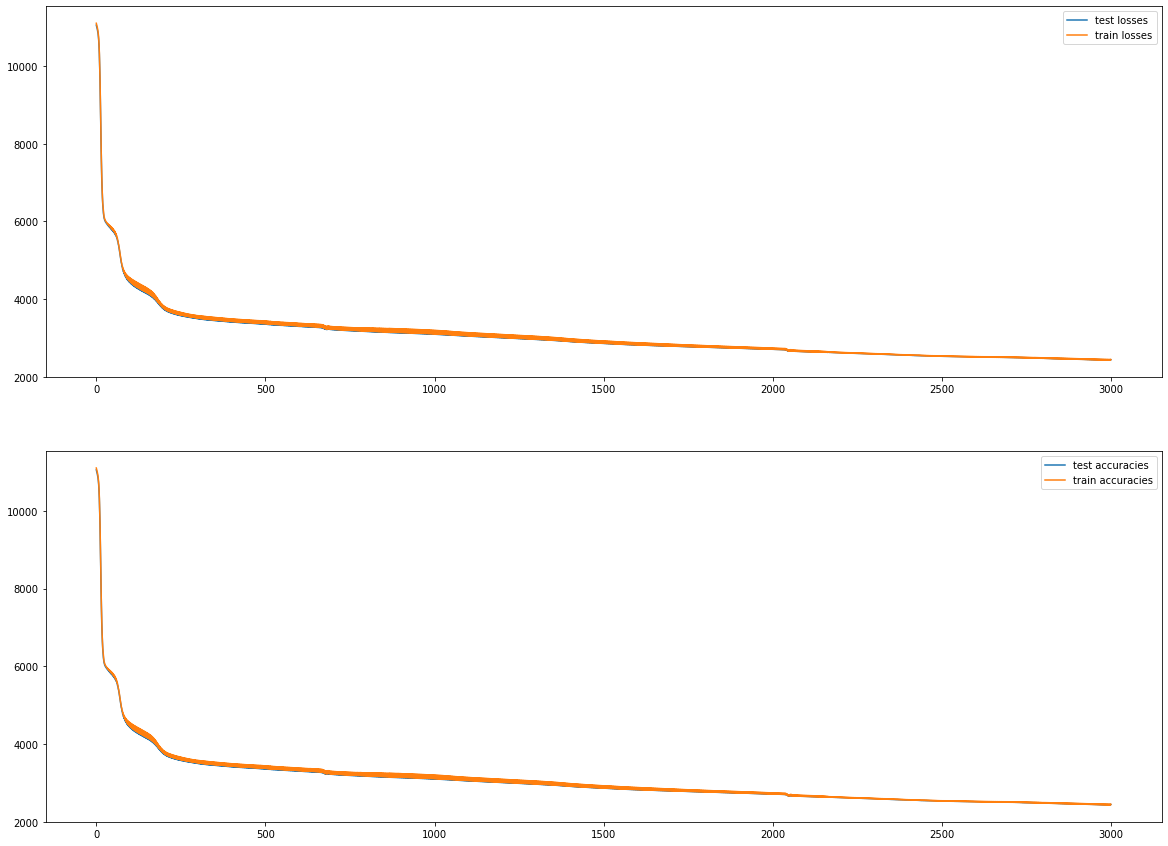

In [62]:
def get_noisy_images(x:tf.Tensor, \
                     noise_factor:float=0.2, \
                     clip_min_value:float=0.0, \
                     clip_max_value:float=1.0) ->tf.Tensor:
  x_noisy = x + noise_factor * tf.random.normal(shape=x.shape)
  x_noisy = tf.clip_by_value(x_noisy, \
                             clip_value_min=clip_min_value, \
                             clip_value_max=clip_max_value)
  return x_noisy

def make_layer(shape:list, layername:str)->tf.Variable:
  return tf.Variable(tf.random.normal(shape, mean=0, stddev=0.05, \
                                      dtype=tf.dtypes.float32),
                                      name=layername)

def q_1_3_1():
  tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
  
  tr_x_noisy = get_noisy_images(tr_x)
  te_x_noisy = get_noisy_images(te_x)

  network = [
             (make_layer([128, 784], "L1 weights"),
              make_layer([128, 1], "L1 bias"),
              tf.nn.relu,
              False,),
             (make_layer([64, 128], "L2 weights"),
              make_layer([64, 1], "L2 bias"),
              tf.nn.relu,
              False,),
             (make_layer([32, 64], "L3 weights"),
              make_layer([32, 1], "L3 bias"),
              tf.nn.relu,
              False,),
             (make_layer([64, 32], "L4 weights"),
              make_layer([64, 1], "L4 bias"),
              tf.nn.relu,
              False,),
             (make_layer([128, 64], "L5 weights"),
              make_layer([128, 1], "L5 bias"),
              tf.nn.relu,
              False,),
             (make_layer([784, 128], "L6 weights"),
              make_layer([784, 1], "L6 bias"),
              tf.nn.sigmoid,
              False,),
  ]

  nn = NeuralNetwork(network)
  nn.train_network(3000, \
                   tr_x_noisy, tr_x, \
                   te_x_noisy, te_x, \
                   mean_absolute_error, mean_square_error_image, \
                   use_argmax=False)

  return nn


import matplotlib.pyplot as plt

nn = q_1_3_1()
tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
te_x_noisy = get_noisy_images(te_x)
denoised = nn.predict(te_x_noisy, None)
print(denoised.shape)


plt.rcParams["figure.figsize"] = (20, 15)

def norm(x):
  minimum = np.min(x)
  maximum = np.max(x)
  x = (x - minimum) / (maximum - minimum)
  return x

def norm(x):
  return x

fig, ax = plt.subplots(2)

ax[0].plot(nn.iterations, norm(nn.test_losses), label="test losses")
ax[0].plot(nn.iterations, norm(nn.train_losses), label="train losses")
#ax[0].suptitle("loss")
ax[0].legend()
ax[1].plot(nn.iterations, norm(nn.test_accuracies), label="test accuracies")
ax[1].plot(nn.iterations, norm(nn.train_accuracies), label="train accuracies")
#ax[1].suptitle("accuracy")
ax[1].legend()
plt.show()

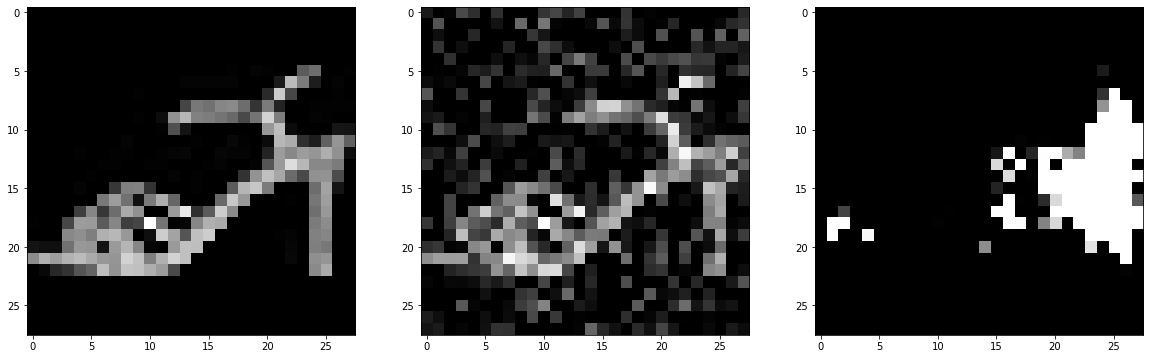

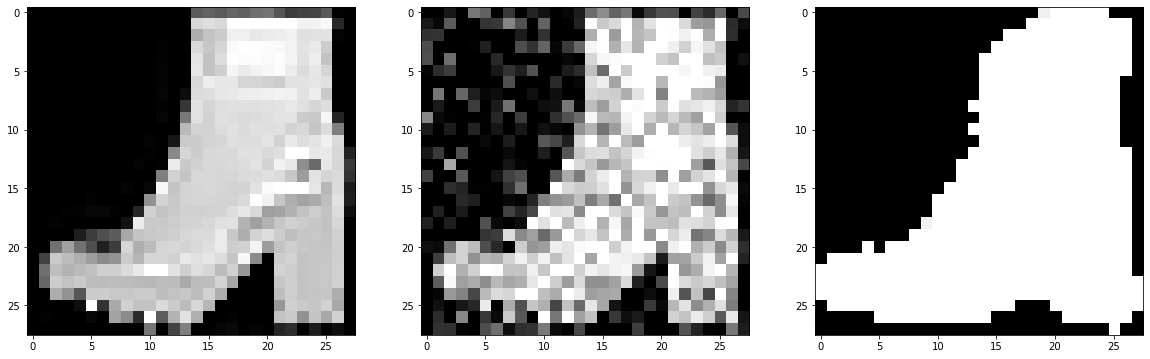

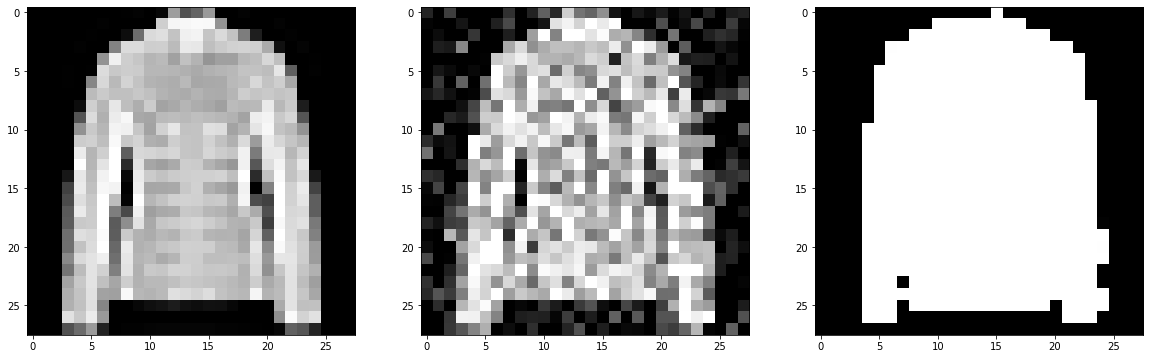

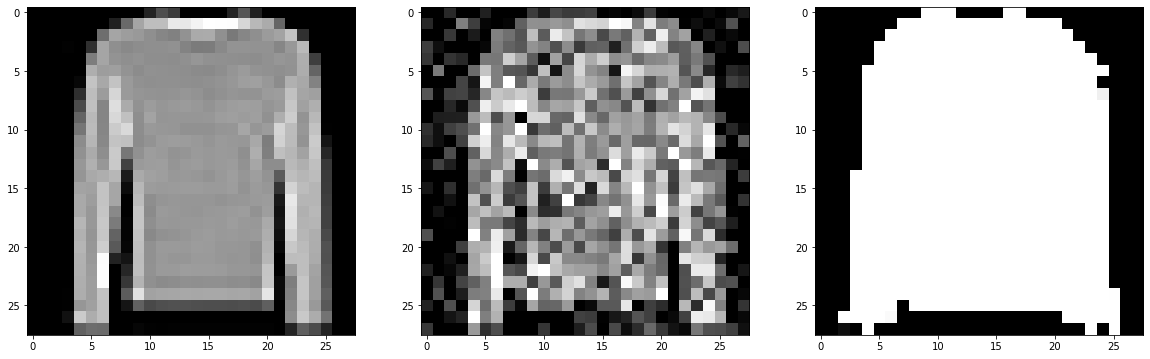

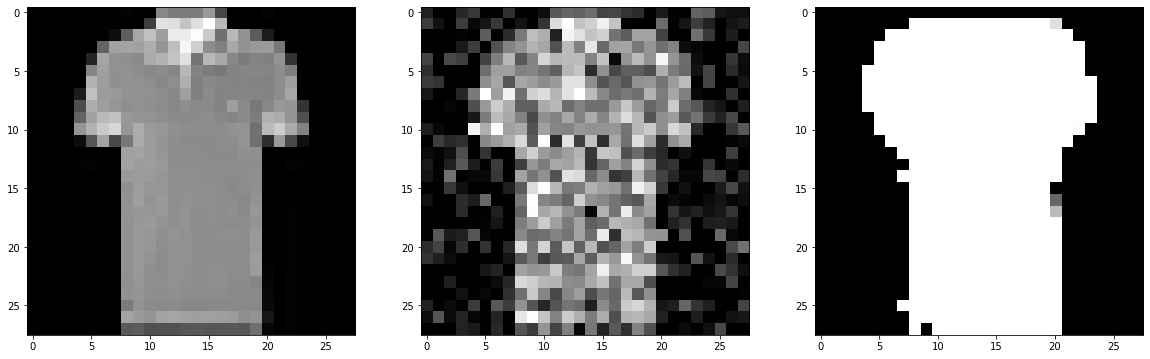

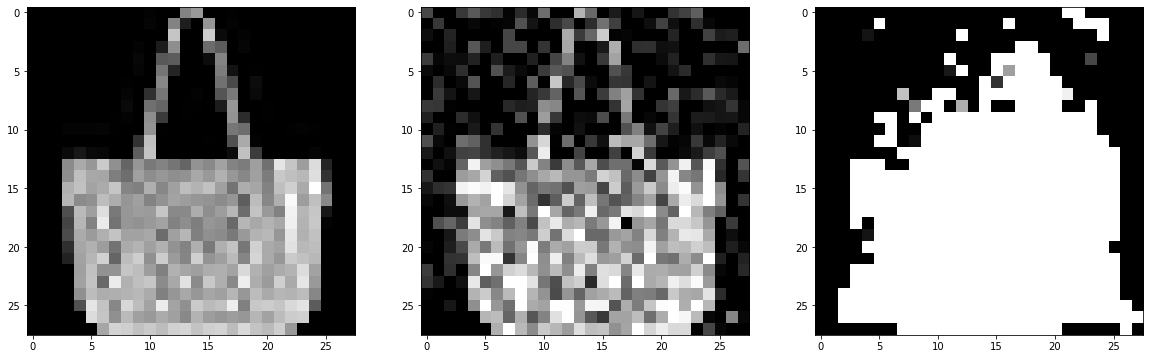

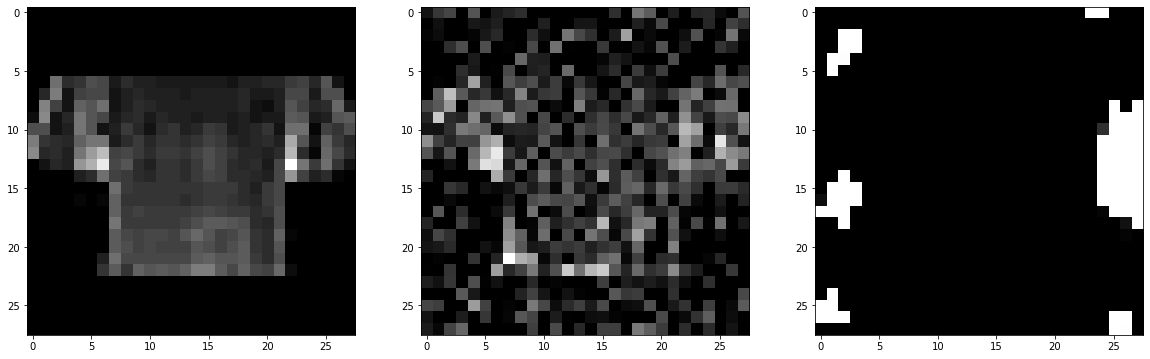

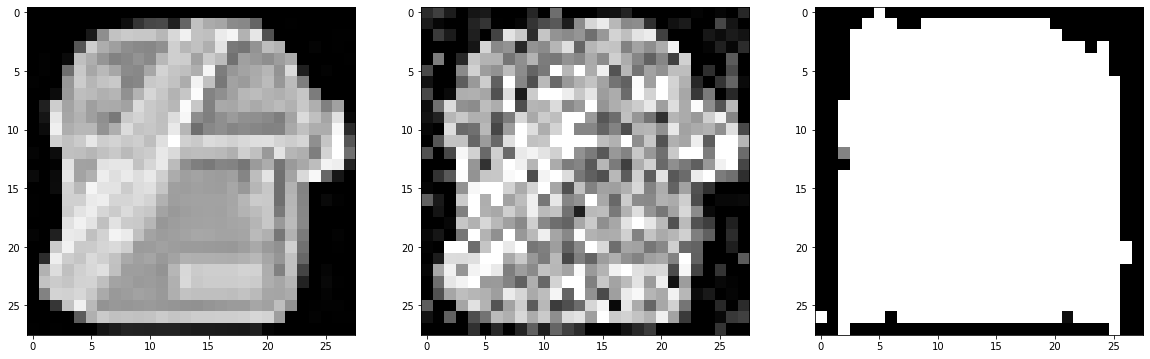

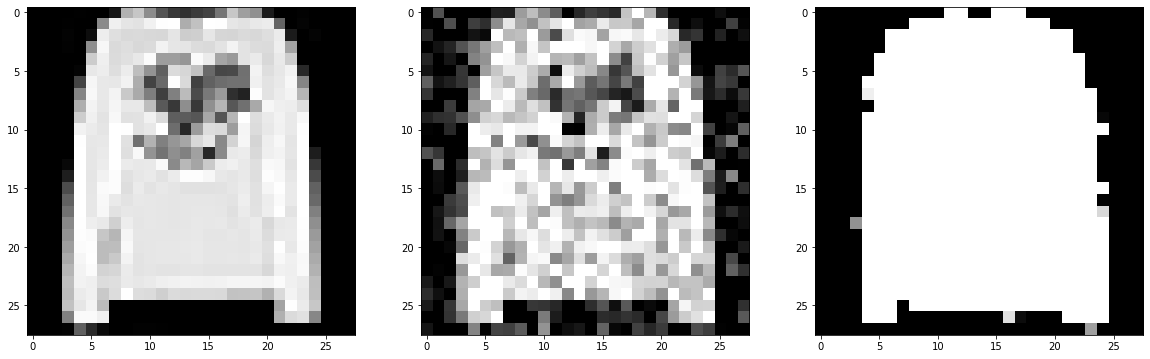

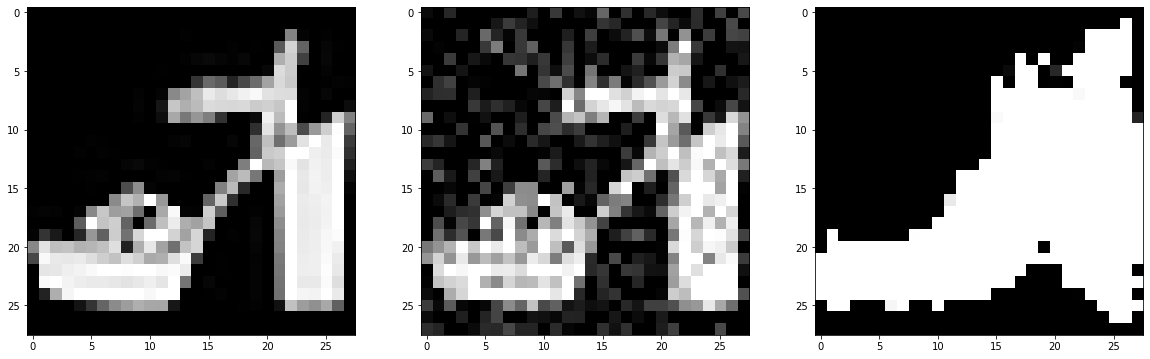

In [63]:
import random
import math

tr_x, tr_y, te_x, te_y = get_fashion_mnist_data()
te_x_noisy = get_noisy_images(te_x)
denoised = nn.predict(te_x_noisy, None)

# te_x          10000x784
# te_x_noisy    10000x784

te_x = tf.multiply(te_x, 255)
te_x = tf.math.round(te_x)
te_x = te_x.numpy()

te_x_noisy = tf.multiply(te_x_noisy, 255)
te_x_noisy = tf.math.round(te_x_noisy)
te_x_noisy = te_x_noisy.numpy()

te_x_denoised = tf.transpose(nn.predict(te_x_noisy, None))
te_x_denoised = tf.multiply(te_x_denoised, 255)
te_x_denoised = tf.math.round(te_x_denoised)
te_x_denoised = te_x_denoised.numpy()

def draw_graph(noisy:np.ndarray, \
               denoised:np.ndarray, \
               original:np.ndarray)->None:
  noisy = np.reshape(noisy, (28, 28,))
  denoised = np.reshape(denoised, (28, 28,))
  original = np.reshape(original, (28, 28,))
  fig, ax = plt.subplots(1, 3)
  ax[0].imshow(original, cmap='gray')
  ax[1].imshow(noisy, cmap='gray')
  ax[2].imshow(denoised, cmap='gray')
  plt.show()

visited = set()
for i in range(10):
  while True:
    ind = random.randrange(0, te_x_denoised.shape[0])
    if ind not in visited:
      break
  visited.add(ind)
  draw_graph(te_x_noisy[ind,:], te_x_denoised[ind,:], te_x[ind,:])


tf.Tensor(254.17456, shape=(), dtype=float32)
